<a href="https://colab.research.google.com/github/jydiw/nyt-covid-19-data/blob/master/nyt_covid_data_county.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NYTimes COVID-19 EDA and `pandas` Optimization

In [2]:
import numpy as np
import pandas as pd

from urllib.request import urlopen
import json

import itertools

from time import time
from datetime import datetime, timedelta

from shapely.geometry import Polygon

# import nytimes data

New York Times data has a few caveats, including treating New York City, Kansas City, and Joplin as single entities rather than including them in their respective counties. Read their [README](https://github.com/nytimes/covid-19-data/blob/master/README.md) for more information.

In [3]:
with urlopen('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv') as response:
    nyt_df = pd.read_csv(response)
nyt_df.head()

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061.0,1,0
1,2020-01-22,Snohomish,Washington,53061.0,1,0
2,2020-01-23,Snohomish,Washington,53061.0,1,0
3,2020-01-24,Cook,Illinois,17031.0,1,0
4,2020-01-24,Snohomish,Washington,53061.0,1,0


In [4]:
nyt_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322651 entries, 0 to 322650
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    322651 non-null  object 
 1   county  322651 non-null  object 
 2   state   322651 non-null  object 
 3   fips    319303 non-null  float64
 4   cases   322651 non-null  int64  
 5   deaths  322651 non-null  int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 14.8+ MB


In [5]:
for col in nyt_df.select_dtypes(include='object').columns:
    print(col)
    print(len(nyt_df[col].unique()))
    print()

date
174

county
1819

state
55



- `fips` should not be numeric. As we'll see down below, we will have to import this as an object type so that we don't convert `float` values to `str`.
- the max for both `cases` and `deaths` is well below the maximum value of `int64`, so we can downcast.
- by nature of the data, the `state`-`county` combinations (and therefore `fips`) are far fewer than the number of entries in our dataset. We can change `state`, `county`, and `fips` to the `category` data type.
- we should probably change `date` into a `datetime` data type. This gives us some flexibility later.

**Why `category`?** The memory of the `object` data type is proportional to its length, whereas for `category` it is proportional to the number of categories plus the length. Given that we have 300k+ rows and only 1814 unique counties, we save memory when converting that column to `category`.

https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html#memory-usage

In [6]:
nyt_df['fips'] = nyt_df['fips'].astype('category')   # doesn't work as intended
nyt_df['cases'] = pd.to_numeric(nyt_df['cases'], downcast='integer')
nyt_df['deaths'] = pd.to_numeric(nyt_df['deaths'], downcast='integer')
nyt_df['state'] = nyt_df['state'].astype('category')
nyt_df['county'] = nyt_df['county'].astype('category')
nyt_df['date'] = pd.to_datetime(nyt_df['date'])
nyt_df.head()

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061.0,1,0
1,2020-01-22,Snohomish,Washington,53061.0,1,0
2,2020-01-23,Snohomish,Washington,53061.0,1,0
3,2020-01-24,Cook,Illinois,17031.0,1,0
4,2020-01-24,Snohomish,Washington,53061.0,1,0


In [7]:
nyt_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322651 entries, 0 to 322650
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    322651 non-null  datetime64[ns]
 1   county  322651 non-null  category      
 2   state   322651 non-null  category      
 3   fips    319303 non-null  category      
 4   cases   322651 non-null  int32         
 5   deaths  322651 non-null  int16         
dtypes: category(3), datetime64[ns](1), int16(1), int32(1)
memory usage: 6.0 MB


We reduce our memory usage by over half. While we were not using an absolute large amount of memory prior to optimization, it's good practice to optimize your code.

Combining into one function:

In [94]:
def optimize(df):
    '''
    Optimizes the data types in a pandas dataframe.
    '''
    dft = df.copy()
    # converts to datetime if possible
    dft = dft.apply(lambda col: pd.to_datetime(col, errors='ignore') if col.dtypes=='object' else col)
    # if there are less than half as many unique values as there are rows, convert to category
    for col in dft.select_dtypes(include='object'):
        if len(dft[col].unique()) / len(df[col]) < 0.5:
            dft[col] = dft[col].astype('category')
    # downcasts numeric columns if possible
    dft = dft.apply(lambda col: pd.to_numeric(col, downcast='integer') if col.dtypes=='int64' else col)
    dft = dft.apply(lambda col: pd.to_numeric(col, downcast='float') if col.dtypes=='float64' else col)
    return dft

In [9]:
with urlopen('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv') as response:
    nyt_df = optimize(pd.read_csv(response, dtype={'fips':'str'}))
nyt_df.head()

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061,1,0
1,2020-01-22,Snohomish,Washington,53061,1,0
2,2020-01-23,Snohomish,Washington,53061,1,0
3,2020-01-24,Cook,Illinois,17031,1,0
4,2020-01-24,Snohomish,Washington,53061,1,0


In [10]:
nyt_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322651 entries, 0 to 322650
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    322651 non-null  datetime64[ns]
 1   county  322651 non-null  category      
 2   state   322651 non-null  category      
 3   fips    319303 non-null  category      
 4   cases   322651 non-null  int32         
 5   deaths  322651 non-null  int16         
dtypes: category(3), datetime64[ns](1), int16(1), int32(1)
memory usage: 6.0 MB


# import census data

In [3]:
pop_df = pd.read_csv('data/pop_df.csv')
pop_df.head()

,state,county,population,fips
0,Alabama,Autauga,55869,01001
1,Alabama,Baldwin,223234,01003
2,Alabama,Barbour,24686,01005
3,Alabama,Bibb,22394,01007
4,Alabama,Blount,57826,01009


In [17]:
nyt_df = nyt_df[nyt_df['county'] != 'Unknown']
list(set(nyt_df['county']) - set(pop_df['county']))

['Kansas City', 'Joplin', 'New York City']

In [20]:
nyt_df['fips'] = nyt_df['fips'].astype('object')
nyt_df.loc[nyt_df['county'] == 'New York City','fips'] = 'nyc'
nyt_df.loc[nyt_df['county'] == 'Kansas City','fips'] = 'kc'
nyt_df.loc[nyt_df['county'] == 'Joplin','fips'] = 'jm'
nyt_df['fips'] = nyt_df['fips'].astype('category')

# import geojson for boundaries and census areas

In [29]:
def county_area(i, j=county_json):
    for d in j['features']:
        if d['id'] == i:
            return d['properties']['CENSUSAREA']

In [30]:
for fips in fips_to_add_to_json:
    print(county_area(fips))

439.76
302.64
17081.43
2093.9
35.56


# add latitude and longitude coordinates

In [31]:
def centroid(i, j=county_json):
    for d in j['features']:
        if d['id'] == i:
            shapes = np.array(d['geometry']['coordinates']).flatten()
            try:
                areas = [Polygon(shape).area for shape in shapes]
                p = Polygon(shapes[areas.index(max(areas))])
                lon, lat = p.centroid.coords[0]
            except:
                shapes = np.reshape(shapes, (-1, 2))
                p = Polygon(shapes)
                lon, lat = p.centroid.coords[0]
            return lon, lat

In [32]:
for d in county_json['features']:
    if d['id'] == fips_to_add_to_json[0]:
        shapes = d['geometry']['coordinates']

print(len(shapes))
areas = [Polygon(shape).area for shape in shapes]
areas

2


[0.0899984999999991, 0.035515830415977646]

In [33]:
for fips in fips_to_add_to_json:
    print(centroid(fips))

(-94.5544223903731, 39.1271954680726)
(-73.93936847673419, 40.66351613943744)
(-163.5144805328244, 62.15824463834583)
(-102.72778156028366, 43.18510744680853)
(-94.50560539941796, 37.07916084816835)


# add area and coordinates to `pop_df`

In [34]:
tick = time()
pop_df['area'] = pop_df['fips'].apply(county_area)
pop_df['lon'], pop_df['lat'] = zip(*pop_df['fips'].apply(centroid).to_list())
pop_df = optimize(pop_df)
tock = time()
print(tock - tick)

0.759967565536499


In [35]:
pop_df.head()

,state,county,population,fips,area,lon,lat
0,Alabama,Autauga,55869,01001,594.435974,-86.641197,32.536152
1,Alabama,Baldwin,223234,01003,1589.784058,-87.723953,30.725863
2,Alabama,Barbour,24686,01005,884.875977,-85.389244,31.867889
3,Alabama,Bibb,22394,01007,622.581970,-87.124962,32.996456
4,Alabama,Blount,57826,01009,644.776001,-86.569756,33.985249


In [36]:
pop_df.to_csv('data/pop_df.csv', index=False)

# merge `nyt_df` and `pop_df` for per capita and per capita * area feature engineering

In [37]:
pop_df.columns.difference(nyt_df.columns)

Index(['area', 'lat', 'lon', 'population'], dtype='object')

In [38]:
tick = time()

df = nyt_df.merge(pop_df[['fips', 'area', 'population', 'lat', 'lon']], on='fips')
df[['cases_per_100k', 'deaths_per_100k']] = df[['cases', 'deaths']].div(df['population'], axis=0) * 100_000
df[['case_density', 'death_density']] = df[['cases', 'deaths']].div(df['population'], axis=0).div(df['area'], axis=0) * 100_000
df = df.sort_values(by=['date', 'fips'])

tock = time()
print(tock - tick)

df.head()

0.2683084011077881


,date,county,state,fips,cases,deaths,area,population,lat,lon,cases_per_100k,deaths_per_100k,case_density,death_density
0,2020-01-21,Snohomish,Washington,53061,1,0,2087.272949,822083,48.046917,-121.692780,0.121642,0.0,0.000058,0.0
1,2020-01-22,Snohomish,Washington,53061,1,0,2087.272949,822083,48.046917,-121.692780,0.121642,0.0,0.000058,0.0
2,2020-01-23,Snohomish,Washington,53061,1,0,2087.272949,822083,48.046917,-121.692780,0.121642,0.0,0.000058,0.0
174,2020-01-24,Cook,Illinois,17031,1,0,945.325989,5150233,41.839622,-87.817429,0.019417,0.0,0.000021,0.0
3,2020-01-24,Snohomish,Washington,53061,1,0,2087.272949,822083,48.046917,-121.692780,0.121642,0.0,0.000058,0.0


## `join` performance considerations

In [39]:
tick = time()

nyt_df1 = nyt_df.set_index(['fips', 'date'])
pop_df1 = pop_df.set_index('fips')

df1 = nyt_df1.join(pop_df1[['area', 'population', 'lat', 'lon']], on='fips', how='left')
df1[['cases_per_100k', 'deaths_per_100k']] = df1[['cases', 'deaths']].div(df1['population'], axis=0) * 100_000
df1[['case_density', 'death_density']] = df1[['cases', 'deaths']].div(df1['population'], axis=0).div(df1['area'], axis=0) * 100_000
df1 = df1.sort_values(by=['date', 'fips'])

tock = time()
print(tock - tick)

df1.head()

0.1825113296508789


county       state  cases  deaths         area  \
fips  date                                                            
53061 2020-01-21  Snohomish  Washington      1       0  2087.272949   
      2020-01-22  Snohomish  Washington      1       0  2087.272949   
      2020-01-23  Snohomish  Washington      1       0  2087.272949   
17031 2020-01-24       Cook    Illinois      1       0   945.325989   
53061 2020-01-24  Snohomish  Washington      1       0  2087.272949   

                  population        lat         lon  cases_per_100k  \
fips  date                                                            
53061 2020-01-21      822083  48.046917 -121.692780        0.121642   
      2020-01-22      822083  48.046917 -121.692780        0.121642   
      2020-01-23      822083  48.046917 -121.692780        0.121642   
17031 2020-01-24     5150233  41.839622  -87.817429        0.019417   
53061 2020-01-24      822083  48.046917 -121.692780        0.121642   

                  deaths_per_100k  case_density  death_density  
fips  date                                                      
53061 2020-01-21              0.0      0.000058            0.0  
      2020-01-22              0.0      0.000058            0.0  
      2020-01-23              0.0      0.000058            0.0  
17031 2020-01-24              0.0      0.000021            0.0  
53061 2020-01-24              0.0      0.000058            0.0

## `groupby` performance considerations

Naively, I looped through each column to make my engineered columns, but found it to be quite slow.

In [40]:
cols = ['cases', 'deaths', 'cases_per_100k', 'deaths_per_100k', 'case_density', 'death_density']

new_cols = ['new_' + c for c in cols]
delta_cols = ['delta_' + c for c in new_cols]
new_cols_7d = [c + '_7d' for c in new_cols]
delta_cols_7d = [c + '_7d' for c in delta_cols]

In [41]:
df2 = df.copy()

ding = time()

cols = ['cases', 'deaths', 'cases_per_100k', 'deaths_per_100k', 'case_density', 'death_density']

# not sure why this can't be more vectorized
for i, col in enumerate(cols):
    print(col)
    tick = time()
    
    # new cases
    df2[new_cols[i]] = df2.groupby(by='fips')[col].diff().fillna(0)
    df2.loc[df2[new_cols[i]] < 0, new_cols[i]] = 0                # some counties revise their numbers
    
    # change in new cases
    df2[delta_cols[i]] = df2.groupby(by='fips')[new_cols[i]].diff().fillna(0)
    
    # rolling average of new cases
    df2[new_cols_7d[i]] = df2.groupby(by='fips')[new_cols[i]].apply(lambda x: x.rolling(7, min_periods=1).mean())
    
    # rolling average of change in new cases
    df2[delta_cols_7d[i]] = df2.groupby(by='fips')[delta_cols[i]].apply(lambda x: x.rolling(7, min_periods=1).mean())
    
    tock = time()
    print(tock - tick)
    print()
    
dong = time()
print(dong - ding)

df2.head()

cases
3.169553518295288

deaths
3.213380813598633

cases_per_100k
3.3470518589019775

deaths_per_100k
3.3370771408081055

case_density
3.3979175090789795

death_density
3.344085454940796

19.80906629562378


,date,county,state,fips,cases,deaths,area,population,lat,lon,...,new_deaths_per_100k_7d,delta_new_deaths_per_100k_7d,new_case_density,delta_new_case_density,new_case_density_7d,delta_new_case_density_7d,new_death_density,delta_new_death_density,new_death_density_7d,delta_new_death_density_7d
0,2020-01-21,Snohomish,Washington,53061,1,0,2087.272949,822083,48.046917,-121.692780,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-01-22,Snohomish,Washington,53061,1,0,2087.272949,822083,48.046917,-121.692780,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-01-23,Snohomish,Washington,53061,1,0,2087.272949,822083,48.046917,-121.692780,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
174,2020-01-24,Cook,Illinois,17031,1,0,945.325989,5150233,41.839622,-87.817429,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-01-24,Snohomish,Washington,53061,1,0,2087.272949,822083,48.046917,-121.692780,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Dataframes can be passed when calculating rolling averages, so changing that bit of code significantly improved performance.

In [42]:
df3 = df.copy()

ding = time()

# we have to loop through the columns for groupby.diff
# the line below throws a NotImplementedError
# df1[new_cols] = grouped[cols].diff().fillna(0)

for i, col in enumerate(cols):
    print(col)
    tick = time()
    # new cases
    df3[new_cols[i]] = df3.groupby(by='fips')[col].diff().fillna(0)
    df3.loc[df3[new_cols[i]] < 0, new_cols[i]] = 0
    # change in new cases
    df3[delta_cols[i]] = df3.groupby(by='fips')[new_cols[i]].diff().fillna(0)
    tock = time()
    print(tock - tick)
    print()

# making new_cols_7d and delta_cols_7d
grouped = df3.groupby(by='fips')
df3[new_cols_7d] = grouped[new_cols].apply(lambda x: x.rolling(7, min_periods=1).mean())
df3[delta_cols_7d] = grouped[delta_cols].apply(lambda x: x.rolling(7, min_periods=1).mean())
    
dong = time()
print(dong - ding)
df1.head()

cases
1.0232651233673096

deaths
0.9734237194061279

cases_per_100k
1.0103001594543457

deaths_per_100k
0.9364950656890869

case_density
1.0013244152069092

death_density
1.0032885074615479

11.826380968093872


county       state  cases  deaths         area  \
fips  date                                                            
53061 2020-01-21  Snohomish  Washington      1       0  2087.272949   
      2020-01-22  Snohomish  Washington      1       0  2087.272949   
      2020-01-23  Snohomish  Washington      1       0  2087.272949   
17031 2020-01-24       Cook    Illinois      1       0   945.325989   
53061 2020-01-24  Snohomish  Washington      1       0  2087.272949   

                  population        lat         lon  cases_per_100k  \
fips  date                                                            
53061 2020-01-21      822083  48.046917 -121.692780        0.121642   
      2020-01-22      822083  48.046917 -121.692780        0.121642   
      2020-01-23      822083  48.046917 -121.692780        0.121642   
17031 2020-01-24     5150233  41.839622  -87.817429        0.019417   
53061 2020-01-24      822083  48.046917 -121.692780        0.121642   

                  deaths_per_100k  case_density  death_density  
fips  date                                                      
53061 2020-01-21              0.0      0.000058            0.0  
      2020-01-22              0.0      0.000058            0.0  
      2020-01-23              0.0      0.000058            0.0  
17031 2020-01-24              0.0      0.000021            0.0  
53061 2020-01-24              0.0      0.000058            0.0

`groupby.diff` performs rather slowly. The process is much faster when performing the tasks more explicitly. The following code was adapted from [this stackoverflow answer](https://stackoverflow.com/a/53159140).

In [43]:
df4 = df.copy()

ding = time()

# making new_cols
grouped = df4.groupby(by='fips')
df4[new_cols] = df4[cols] - grouped[cols].shift()
df4[new_cols] = df4[new_cols].fillna(0)
df4[new_cols] = df4[new_cols].clip(lower=0)

# making delta_cols
grouped = df4.groupby(by='fips')
df4[delta_cols] = df4[new_cols] - grouped[new_cols].shift()
df4[delta_cols] = df4[delta_cols].fillna(0)

# making new_cols_7d and delta_cols_7d
grouped = df4.groupby(by='fips')
df4[new_cols_7d] = grouped[new_cols].apply(lambda x: x.rolling(7, min_periods=1).mean())
df4[delta_cols_7d] = grouped[delta_cols].apply(lambda x: x.rolling(7, min_periods=1).mean())

dong = time()
print(dong - ding)
df4.head()

6.198784589767456


,date,county,state,fips,cases,deaths,area,population,lat,lon,...,new_cases_per_100k_7d,new_deaths_per_100k_7d,new_case_density_7d,new_death_density_7d,delta_new_cases_7d,delta_new_deaths_7d,delta_new_cases_per_100k_7d,delta_new_deaths_per_100k_7d,delta_new_case_density_7d,delta_new_death_density_7d
0,2020-01-21,Snohomish,Washington,53061,1,0,2087.272949,822083,48.046917,-121.692780,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-01-22,Snohomish,Washington,53061,1,0,2087.272949,822083,48.046917,-121.692780,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-01-23,Snohomish,Washington,53061,1,0,2087.272949,822083,48.046917,-121.692780,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
174,2020-01-24,Cook,Illinois,17031,1,0,945.325989,5150233,41.839622,-87.817429,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-01-24,Snohomish,Washington,53061,1,0,2087.272949,822083,48.046917,-121.692780,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
df2.sort_index(axis=1).equals(df3.sort_index(axis=1))

True

In [45]:
df2.sort_index(axis=1).equals(df4.sort_index(axis=1))

True

In [46]:
df4.to_csv('data/df.csv', index=False)

## using multiindex df1

In [47]:
df5 = df1.copy()

ding = time()

# making new_cols
grouped = df5.groupby(level=0)
df5[new_cols] = df5[cols] - grouped[cols].shift()
df5[new_cols] = df5[new_cols].fillna(0)
df5[new_cols] = df5[new_cols].clip(lower=0)

# making delta_cols
grouped = df5.groupby(level=0)
df5[delta_cols] = df5[new_cols] - grouped[new_cols].shift()
df5[delta_cols] = df5[delta_cols].fillna(0)

# making new_cols_7d and delta_cols_7d
grouped = df5.groupby(level=0)
df5[new_cols_7d] = grouped[new_cols].apply(lambda x: x.rolling(7, min_periods=1).mean())
df5[delta_cols_7d] = grouped[delta_cols].apply(lambda x: x.rolling(7, min_periods=1).mean())

dong = time()
print(dong - ding)
df5.head()

21.261142015457153


county       state  cases  deaths         area  \
fips  date                                                            
53061 2020-01-21  Snohomish  Washington      1       0  2087.272949   
      2020-01-22  Snohomish  Washington      1       0  2087.272949   
      2020-01-23  Snohomish  Washington      1       0  2087.272949   
17031 2020-01-24       Cook    Illinois      1       0   945.325989   
53061 2020-01-24  Snohomish  Washington      1       0  2087.272949   

                  population        lat         lon  cases_per_100k  \
fips  date                                                            
53061 2020-01-21      822083  48.046917 -121.692780        0.121642   
      2020-01-22      822083  48.046917 -121.692780        0.121642   
      2020-01-23      822083  48.046917 -121.692780        0.121642   
17031 2020-01-24     5150233  41.839622  -87.817429        0.019417   
53061 2020-01-24      822083  48.046917 -121.692780        0.121642   

                  deaths_per_100k  ...  new_cases_per_100k_7d  \
fips  date                         ...                          
53061 2020-01-21              0.0  ...                    0.0   
      2020-01-22              0.0  ...                    0.0   
      2020-01-23              0.0  ...                    0.0   
17031 2020-01-24              0.0  ...                    0.0   
53061 2020-01-24              0.0  ...                    0.0   

                  new_deaths_per_100k_7d  new_case_density_7d  \
fips  date                                                      
53061 2020-01-21                     0.0                  0.0   
      2020-01-22                     0.0                  0.0   
      2020-01-23                     0.0                  0.0   
17031 2020-01-24                     0.0                  0.0   
53061 2020-01-24                     0.0                  0.0   

                  new_death_density_7d  delta_new_cases_7d  \
fips  date                                                   
53061 2020-01-21                   0.0                 0.0   
      2020-01-22                   0.0                 0.0   
      2020-01-23                   0.0                 0.0   
17031 2020-01-24                   0.0                 0.0   
53061 2020-01-24                   0.0                 0.0   

                  delta_new_deaths_7d  delta_new_cases_per_100k_7d  \
fips  date                                                           
53061 2020-01-21                  0.0                          0.0   
      2020-01-22                  0.0                          0.0   
      2020-01-23                  0.0                          0.0   
17031 2020-01-24                  0.0                          0.0   
53061 2020-01-24                  0.0                          0.0   

                  delta_new_deaths_per_100k_7d  delta_new_case_density_7d  \
fips  date                                                                  
53061 2020-01-21                           0.0                        0.0   
      2020-01-22                           0.0                        0.0   
      2020-01-23                           0.0                        0.0   
17031 2020-01-24                           0.0                        0.0   
53061 2020-01-24                           0.0                        0.0   

                  delta_new_death_density_7d  
fips  date                                    
53061 2020-01-21                         0.0  
      2020-01-22                         0.0  
      2020-01-23                         0.0  
17031 2020-01-24                         0.0  
53061 2020-01-24                         0.0  

[5 rows x 36 columns]

This process is slower using multiindex.

## rolling regression instead of rolling average

In [229]:
df6 = df6.sort_values(by=['fips', 'date'])
df6['new_cases_slope'] = 0
df6.head()

,date,county,state,fips,cases,deaths,area,population,lat,lon,...,delta_new_deaths_7d,delta_new_cases_per_100k_7d,delta_new_deaths_per_100k_7d,delta_new_case_density_7d,delta_new_death_density_7d,date_ord,new_case_cov,new_case_var,new_case_slope,new_cases_slope
143109,2020-03-24,Autauga,Alabama,01001,1,0,594.435974,55869,32.536152,-86.641197,...,0.0,0.000000,0.0,0.000000,0.0,737508,NaN,NaN,NaN,0
143110,2020-03-25,Autauga,Alabama,01001,4,0,594.435974,55869,32.536152,-86.641197,...,0.0,2.684852,0.0,0.004517,0.0,737509,NaN,NaN,NaN,0
143111,2020-03-26,Autauga,Alabama,01001,6,0,594.435974,55869,32.536152,-86.641197,...,0.0,1.193268,0.0,0.002007,0.0,737510,NaN,NaN,NaN,0
143112,2020-03-27,Autauga,Alabama,01001,6,0,594.435974,55869,32.536152,-86.641197,...,0.0,0.000000,0.0,0.000000,0.0,737511,NaN,NaN,NaN,0
143113,2020-03-28,Autauga,Alabama,01001,6,0,594.435974,55869,32.536152,-86.641197,...,0.0,0.000000,0.0,0.000000,0.0,737512,NaN,NaN,NaN,0


In [246]:
window = 7

for col in new_cols:
    print(col)
    ding = time()
    slope_col = col + '_slope'
    df6[slope_col] = 0
    for fips in df6['fips'].unique():
        dft = df6[df6['fips'] == fips]
        l = len(dft)
        slopes = list(np.zeros(window-1))
        if l >= window:
            for i in range(l+1-window):
                x = np.arange(window)
                y = dft[col][i:i+7]
                slopes.append(np.polyfit(x, y, 1)[0])
            df6.loc[df6['fips'] == fips, slope_col] = slopes
        else:
            df6.loc[df6['fips'] == fips, slope_col] = list(np.zeros(l))
    dong = time()
    print(dong - ding)
    print()

new_cases
75.06832599639893

new_deaths
74.39211344718933

new_cases_per_100k
75.92802476882935

new_deaths_per_100k
75.29871582984924

new_case_density
74.87079930305481

new_death_density
74.50383639335632



In [251]:
df6[df6['fips'] == 'nyc'][['new_deaths','delta_new_deaths_7d', 'new_deaths_slope']].tail(20)

,new_deaths,delta_new_deaths_7d,new_deaths_slope
3862,21.0,0.285714,0.428571
3863,21.0,-0.714286,-0.678571
3864,18.0,-1.428571,-1.642857
3865,37.0,0.000000,1.071429
3866,20.0,1.571429,-2.035714
3867,27.0,-1.000000,-1.214286
3868,1.0,-6.000000,-1.642857
3869,625.0,86.285713,63.142857
3870,8.0,-1.857143,40.250000
3871,19.0,0.142857,18.571429


In [252]:
df6 = optimize(df6)

In [253]:
df6.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 319570 entries, 143109 to 3881
Data columns (total 48 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   date                          319570 non-null  datetime64[ns]
 1   county                        319570 non-null  category      
 2   state                         319570 non-null  category      
 3   fips                          319570 non-null  category      
 4   cases                         319570 non-null  int32         
 5   deaths                        319570 non-null  int16         
 6   area                          319570 non-null  float32       
 7   population                    319570 non-null  int32         
 8   lat                           319570 non-null  float32       
 9   lon                           319570 non-null  float32       
 10  cases_per_100k                319570 non-null  float32       
 11  deaths_per

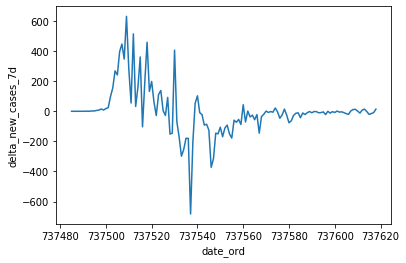

In [258]:
sns.lineplot(x='date_ord', y='delta_new_cases_7d', data=df6[df6['county'] == 'New York City'])

In [259]:
df6.to_csv('data/df-1.csv', index=False)